Langevin
===

**Autor:** Mateus de Jesus Mendes

# Introdução

### Importação de Bibliotecas

In [1]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from plotly.subplots import make_subplots
from scipy.stats import norm, rayleigh, maxwell
from tabulate import tabulate
from scipy import stats

# Equação de Langevin

$$
m\frac{dv}{dt} = -\gamma v + \sigma \xi(t)
$$

Breve modelagem da Equação de Langevin:

In [2]:
# Parâmetros do modelo
m = 1.0     # Massa da partícula
gamma = 1.0 # Coeficiente de atrito viscoso
sigma = 1.0 # Amplitude do ruído

# Tempo
dt = 1e-3     # Passo temporal
T = 10        # Tempo total de simulação
N = int(T/dt) # Malha temporal

# Variáveis dinâmicas
v = np.zeros(N) # Vetor velocidade
x = np.zeros(N) # Vetor posição

# Condições iniciais
v[0] = 0.0
x[0] = 0.0

# Integração Euler-Maruyama
for t in range(N-1):
    xi = np.random.normal(0, 1)               # White-noise N(0,1)
    drift = -(gamma/m) * v[t]                # Termo determinístico
    diffusion = (sigma/m) * np.sqrt(dt) * xi # Termo estocástico discretizado

    v[t+1]= v[t] + drift * dt + diffusion    # Fórmula de Euler-Maruyama
    x[t+1] = x[t] + v[t] * dt                # Atualização da posição

fig = go.Figure()
fig.add_trace(go.Scatter(x=[_ for _ in range(N-1)], y=x))
fig.update_layout(title=dict(text='Evolução Temporal da Posição'))

Visualização da evolução temporal da posição:

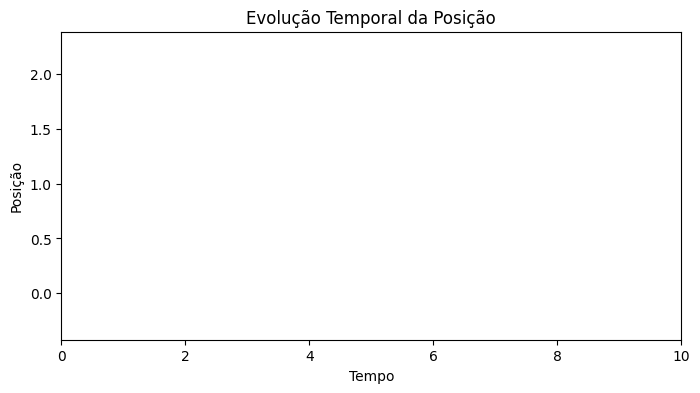

In [3]:
time = np.linspace(0, T, N)

# Amostragem robusta
max_frames = 200
skip = max(1, N // max_frames)

t_res = time[::skip]
x_res = x[::skip]
frames = len(t_res)

fig, ax = plt.subplots(figsize=(8,4))
ax.set_title('Evolução Temporal da Posição')
ax.set_xlabel('Tempo')
ax.set_ylabel('Posição')
ax.set_xlim(0, T)
ax.set_ylim(x_res.min()*1.05, x_res.max()*1.05)

line, = ax.plot([], [], lw=1.8)
point, = ax.plot([], [], "o", markersize=6)

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def update(i):
    # Garante que nunca ultrapassa o limite
    if i >= frames:
        i = frames - 1

    # Transformar arrays em listas para evitar o erro "x must be a sequence"
    t_list = t_res[:i+1].tolist()
    x_list = x_res[:i+1].tolist()

    line.set_data(t_list, x_list)
    point.set_data([t_res[i]], [x_res[i]])

    return line, point

anim = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=frames,
    interval=50,
    blit=False
)

HTML(anim.to_jshtml())

# Processo de Wiener / Movimento Browniano

A seguinte função constrói um passeio aleatório (*random walk*) isotrópico, como um protótipo do movimento browniano em tempo discreto.

In [4]:
def gerar_trajetoria(num_passos, dimensao=2, passo=1.0):
    """
    Gera uma trajetória browniana simplificada (passeio aleatório) em 1D, 2D ou 3D.

    Cada passo da trajetória é amostrado de forma aleatória, com direção uniforme na esfera unitária da dimensão especificada e comprimento fixo.

    ### Parâmetros
        num_pasos: Número de passos discretos na trajetória.

        dimensao: Número de dimensões do espaço no qual a trajetória ocorre.

        passo: Comprimento de cada passo.
    
    ### Retorna
        posicoes: Array de formato `(num_passos, dimensao)` contendo as posições cumulativas da trajetória em cada passo.

    """

    # Amostragem de vetores gaussianos padrão Z_k ~ N(0, I_d)
    direcoes = np.random.normal(size=(num_passos, dimensao))

    # Normaliza cada vetor para norma 1, produzindo direções uniformes na esfera
    direcoes /= np.linalg.norm(direcoes, axis=1)[:, None]

    # Cada passo tem comprimento fixo: l = passo e direção uniforme
    deslocamentos = passo * direcoes
    
    # Somua cumulativa dos incrementos -> Posição após cada passo
    posicoes = np.cumsum(deslocamentos, axis=0)

    # Retorna a trajetória
    return posicoes

Função para simular o experimento anteriormente delineado, rodando $N$ réplicas independentes (ensaios Monte Carlo) para estimar estatísticas de interesse. A partir disso, espera-se que a Lei dos Grandes Números (LGN) garantirá a convergência das médias amostrais.

In [5]:
def simular_experimento(num_simulacoes, num_passos, dimensao=2, passo=1.0):
    """
    Executa múltiplas simulações de trajetórias em um espaço de dimensão arbitrária.

    Cada trajetória é gerada passo a passo por meio da função `gerar_trajetoria`, e a posição final de cada simulação é armazenada para 
    análises estatísticas posteriores.

    ### Parâmetros
        num_simulacoes: Número de simulações a serem executadas.

        num_passos: Número de passos discretos em cada trajetória.

        dimensao: Número de dimensões do espaço no qual a trajetória ocorre.

        passo: Comprimento de cada passo na simulação.
    
    ### Retorna
        Uma tupla contendo dois arrays do NumPy:
        - trajetorias : np.ndarray
            Array de formato `(num_simulacoes, num_passos, dimensao)` com todas as trajetórias simuladas.
        - posicoes_finais : np.ndarray
            Array de formato `(num_simulacoes, dimensao)` com a última posição de cada trajetória.
    """
    
    # Armazena a trajetória de cada simulação para posteriores visualizações
    trajetorias = []

    # Armazena a última posição da trajetória de cada simulação para estatísticas posteriores
    posicoes_finais = []

    for _ in range(num_simulacoes):
        traj = gerar_trajetoria(num_passos, dimensao, passo) # Executa a simulação
        trajetorias.append(traj)
        posicoes_finais.append(traj[-1])
    
    # Converte as listas anteriores em arrays de NumPy e retorna em forma de tupla para operações vetorizadas posteriores
    return np.array(trajetorias), np.array(posicoes_finais)

Função para cálculo de algumas métricas dos dados obtidos a partir das simulações, como média, variância e $\mathrm{MSD}$:

In [6]:
def analisar_resultados(posicoes_finais):
    """
    Calcula estatísticas básicas das posições finais de múltiplas trajetórias.

    Esta função calcula a média, variância e Mean Squared Displacement (MSD) das posições finais de um conjunto de trajetórias simuladas, 
    permitindo avaliar a dispersão e o comportamento médio do sistema.
    
    ### Parâmetros
        posicioes_finais: Array de formato `(num_simulacoes, dimensao)` contendo a última posição de cada trajetória simulada.

    ### Retorna
        Dicionário contendo as métricas de média, variância e MSD.
    """
    
    # Quadrado das posições finais
    distancias2 = np.sum(posicoes_finais**2, axis=0)
    
    # Média das posições finais
    media = np.mean(posicoes_finais, axis=0)
    
    # Variância das posições finais
    variancia = np.var(posicoes_finais, axis=0)
    
    # MSD 
    msd = np.mean(distancias2)
    
    # Retorna dicionário contendo as métricas
    return {
        'media': media,
        'variancia': variancia,
        'MSD': msd
    }

Função para plotar as trajetórias obtidas com as $N$ réplicas independentes da simulação:

In [7]:
def plotar_trajetorias(dimensao, trajetorias, num_exemplos=5):
    """
    Plota trajetórias de exemplo em 1D, 2D ou 3D usando Plotly.

    A função seleciona as primeiras trajetórias fornecidas e cria um gráfico interativo correspondente à dimensão do espaço. 
    Para 3D, o ponto de origem é destacado como referência.

    ### Parâmetros
        dimensao: Dimensão do espaço das trajetórias. Aceita 1, 2 ou 3.

        trajetorias: Array de formato `(num_simulacoes, num_passos, dimensao)` contendo as trajetórias simuladas.

        num_exemplos: Número de trajetórias a serem exibidas no gráfico.


    ### Retorna
        A função exibe o gráfico interativo, mas não retorna valores.
    """
    fig = go.Figure()

    # Plot Unidimensional
    if dimensao == 1:
        for traj in trajetorias[:num_exemplos]:
            fig.add_trace(go.Scatter(y=traj[:,0], mode='lines', name='trajetória'))
        fig.update_layout(
            title=f'{num_exemplos} Trajetórias de Exemplo (1D)',
            xaxis_title='Passo',
            yaxis_title='Posição',
            width=1000,
            height=600,
            plot_bgcolor='white')

        # Configuração do background
        fig.update_xaxes(showgrid=True, gridcolor='white', zerolinecolor='darkgray')
        fig.update_yaxes(showgrid=True, gridcolor='white', zerolinecolor='darkgray')

    # Plot Bidimensional
    elif dimensao == 2:
        for traj in trajetorias[:num_exemplos]:
            fig.add_trace(go.Scatter(x=traj[:,0], y=traj[:,1], mode='lines', name='trajetória'))

        fig.update_layout(
            title=f'{num_exemplos} Trajetórias de Exemplo (2D)',
            xaxis_title='X',
            yaxis_title='Y',
            width=1000,
            height=600,
            plot_bgcolor='white')
        
        # Configuração do background
        fig.update_xaxes(showgrid=True, gridcolor='white', zerolinecolor='darkgray')
        fig.update_yaxes(showgrid=True, gridcolor='white', zerolinecolor='darkgray')        

    # Plot Tridimensional    
    elif dimensao == 3:
        for i, traj in enumerate(trajetorias[:num_exemplos]):
            fig.add_trace(go.Scatter3d(x=traj[:,0], y=traj[:,1], z=traj[:,2], mode='lines', name=f'Trajetória {i+1}'))
        
        # Ponto da origem (X=0, Y=0, Z=0)
        fig.add_trace(go.Scatter3d(
            x=[0], y=[0], z=[0],
            mode='markers',
            marker=dict(size=6, color='Black', symbol='circle'),
            name='Origem',
            showlegend=True))
        
        # Configuração do background
        fig.update_layout(
            title=f'{num_exemplos} Trajetórias de Exemplo (3D)',
            width=1000,
            height=800,
            scene=dict(
            xaxis=dict(title='x', showgrid=True, gridcolor='white', zerolinecolor='black'),
            yaxis=dict(title='y', showgrid=True, gridcolor='white', zerolinecolor='black'),
            zaxis=dict(title='z', showgrid=True, gridcolor='white', zerolinecolor='black'),
            aspectmode='data'))

        # Ajusta a área interativa do plot 3D à área da figura
        fig.update_scenes(
            xaxis_title='x', yaxis_title='y', zaxis_title='z', aspectmode='data')

    fig.show()

Função para plotar a distribuição das posições e distâncias finais, a fim de comparar a visão teórica para $R = ||X_t||$:

In [8]:
def plotar_distribuicoes(dimensao, posicoes_finais):
    """
    Plota as distribuições estatísticas das posições finais de trajetórias simuladas.

    ### Parâmetros
        dimensao: Dimensão do espaço das trajetórias. Aceita valores 1, 2 ou 3.

        posicoes_finais: Array de formato `(num_simulacoes, dimensao)` contendo a última posição de cada trajetória simulada.

    ### Retorna
        A função exibe o gráfico interativo, mas não retorna valores.
    """
    coordenada = posicoes_finais[:, 0]
    distancias = np.linalg.norm(posicoes_finais, axis=1)

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Distribuição das Posições Finais Unidimensionais', 'Distribuição da Distância Final'),
        horizontal_spacing=0.15
    )

    # Histograma das coordenadas
    fig.add_trace(
        go.Histogram(x=coordenada, nbinsx=200, histnorm='probability density',
                     name='Coordenada', opacity=0.6, marker_color='royalblue'),
        row=1, col=1
    )
    fig.update_xaxes(title_text="Valor da Coordenada", row=1, col=1)
    fig.update_yaxes(title_text="Densidade de Probabilidade", row=1, col=1)

    # Normal MLE (Most likelihood estimation)
    mu_fit, sigma_fit = norm.fit(coordenada)
    x_norm = np.linspace(coordenada.min(), coordenada.max(), 600)
    fig.add_trace(
        go.Scatter(x=x_norm, y=norm.pdf(x_norm, mu_fit, sigma_fit), mode='lines',
                   name=f'Normal Ajustada',
                   line=dict(width=2)),
        row=1, col=1
    )
    

    # Histograma das distâncias euclidianas
    fig.add_trace(
        go.Histogram(x=distancias, nbinsx=200, histnorm='probability density',
                     name='Distância', opacity=0.6, marker_color='darkorange'),
        row=1, col=2
    )
    fig.update_xaxes(title_text="Distância Final", row=1, col=2)
    fig.update_yaxes(title_text="Densidade de Probabilidade", row=1, col=2)

    # ----- Curvas Teóricas -----
    # Eixo X da distribuição de distâncias finais
    x_dist = np.linspace(0, distancias.max(), 600)

    # Distribuição de Rayleigh teórica ajustada aos dados
    if dimensao == 2:
        loc, scale = rayleigh.fit(distancias, floc=0)
        fig.add_trace(
            go.Scatter(x=x_dist, y=rayleigh.pdf(x_dist, loc=loc, scale=scale), mode='lines',
                       name=f'Rayleigh Ajustada'),
            row=1, col=2
        )

    # Distribuição de Maxwell-Boltzmann teórica ajustada aos dados
    elif dimensao == 3:
        loc, scale = maxwell.fit(distancias, floc=0)
        fig.add_trace(
            go.Scatter(x=x_dist, y=maxwell.pdf(x_dist, loc=loc, scale=scale), mode='lines',
                       name=f'Maxwell-Boltzmann Ajustada'),
            row=1, col=2
        )

    fig.update_layout(width=1000, height=500, showlegend=True, bargap=0.05, plot_bgcolor='rgba(0,0,0,0)')
    fig.show()


Função que unifica todas as demais, executando a simulação e os plots automaticamente:

In [9]:
def rodar_simulacao_completa(num_simulacoes=1000, num_passos=100, dimensao=2, passo=1.0, num_exemplos=5):
    """
    Executa uma simulação completa de trajetórias brownianas, calcula estatísticas e plota visualizações das trajetórias e distribuições finais.
    ### Parâmetros
        num_simulacoes: Número de trajetórias a serem simuladas.

        num_passos: Dimensão do espaço das trajetórias (1, 2 ou 3).

        dimensao: Comprimento de cada passo na simulação.

        passo: Número de trajetórias a serem exibidas nos gráficos de exemplo.
    
    ### Retorna
        Dicionário contendo as métricas calculadas pela função `analisar_resultados()`.
    """
    # Coleta de dados via Monte Carlo
    trajetorias, posicoes_finais = simular_experimento(num_simulacoes, num_passos, dimensao, passo)

    # Calcula média, variâcia e MSD dos dados
    estatisticas = analisar_resultados(posicoes_finais)

    # Visualização
    plotar_trajetorias(dimensao, trajetorias, num_exemplos)
    plotar_distribuicoes(dimensao, posicoes_finais)

    # Retorna o dicionário contendo as estatísticas
    return estatisticas

Roda a simulação $n$-vezes, plotando gráfico da trajetória, distribuição uni-axial e da distância euclidiana final, bem como exibe as métricas de média, variância e $\mathrm{MSD}$:

In [10]:
resultados = rodar_simulacao_completa(num_simulacoes=1_000, num_passos=1_000, dimensao=3, passo=1.0, num_exemplos=5);

# Tabelas das métricas de Média, Variância e MSD
if len(resultados['media']) == 1: # Métricas unidimensionais
        tabela_resultados = [
            ['Média', resultados['media']],
            ['Variância', resultados['variancia']],
            ['MSD', resultados['MSD']]
        ]
        print(tabulate(tabela_resultados, headers=['Métricas', 'X'], tablefmt='github', floatfmt='.2f'))

elif len(resultados['media']) == 2: # Métricas bidimensionais
        tabela_resultados = [
            ['Média', resultados['media'][0], resultados['media'][1]],
            ['Variância', resultados['variancia'][0], resultados['variancia'][1]],
            ['MSD', resultados['MSD']]
        ]
        print(tabulate(tabela_resultados, headers=['Métricas', 'X', 'Y'], tablefmt='github', floatfmt='.2f'))
else: # Métricas n-dimensionais
        tabela_resultados = [
            ['Média', resultados['media'][0], resultados['media'][1], resultados['media'][2]],
            ['Variância', resultados['variancia'][0], resultados['variancia'][1], resultados['variancia'][2]],
            ['MSD', resultados['MSD']]
        ]
        print(tabulate(tabela_resultados, headers=['Métricas', 'X', 'Y', 'Z'], tablefmt='github', floatfmt='.2f'))

| Métricas   |         X |      Y |      Z |
|------------|-----------|--------|--------|
| Média      |      0.35 |  -0.04 |  -0.89 |
| Variância  |    323.04 | 321.26 | 293.87 |
| MSD        | 313029.39 |        |        |


# Euler-Maruyama $\times$ Ornstein-Uhlenbeck

O Processo Ornstein-Uhlenbeck (OU) para a velocidade $v(t)$ corresponde à EDE linear:
$$
mdv = -\gamma v dt + \sigma dW_t
$$

Comumente apresentada sob a forma:
$$
dv = -\frac{\gamma}{m}vdt + \frac{\sigma}{m}dW_t
$$

Essa EDE descreve um processo Gaussiano-Markoviano, com solução explícita (média, variância, autocorrelação exponencial).

A simulação Euler-Maruyama aproxima essa EDE substituindo $dW_t$ por incrementos discretos $\Delta W \sim \sqrt{\Delta t}\mathcal{N}(0,1)$.

### Definições

In [11]:
# Parâmetros físicos
m = 1.0
gamma = 1.0
sigma = 1.0

In [12]:
# Parâmetros numéricos
T = 10.0
dts = [1e-2, 5e-3, 2.5e-3, 1.25e-3]   # Teste de diferentes passos
dt_ref = min(dts) / 10.0              # Passo de referência (gera solução quasi-contínua)
M = 2000                              # Número de trajetórias (para cálculo de estatísticas)
seed = 88
np.random.seed(seed)

### Funções Analíticas

In [13]:
# Funções analíticas do OU (usadas para comparações numérico-analítico)
tau = m / gamma
def v_mean_theo(v0, t): return v0 * np.exp(-gamma * t / m)
def v_var_theo(t): return (sigma**2) / (2*gamma*m) * (1 - np.exp(-2*gamma*t/m))
def Cv_theo(tau_lag): return (sigma**2)/(2*gamma*m) * np.exp(-gamma*np.abs(tau_lag)/m)
def msd_x_theo(t): return (sigma**2)/(gamma**2) * (t - (m/gamma)*(1 - np.exp(-gamma*t/m)))

### Integração Euler-Maruyama

In [14]:
# Integração Euler-Maruyama (gera trajetórias)
def simulate_em(dt, M, T, v0=0.0, x0=0.0, return_paths=False, reuse_dW=None):
    """
    Integração Euler-Maruyama para M trajetórias com passo dt.

    ### Parâmetros
    - dt:
    - M:
    - T:
    - v0:
    - x0:
    - return_paths:
    - reuse_dW:

    ### Retorna
    Tupla contendo, respectivamente:
    - t:
    - v_all:
    - x_all:
    """
    N = int(np.round(T/dt)) + 1 # Malha temporal
    t = np.linspace(0, T, N)    # Vetor temporal
    v_all = np.zeros((M, N))    # Matriz (M trajetórias x N pontos de tempo)
    x_all = np.zeros((M, N))    # Matriz (M trajetórias x N pontos de tempo)
    v_all[:,0] = v0
    x_all[:,0] = x0
    sqrt_dt = np.sqrt(dt)       # Incrementos discretos de Wiener

    if reuse_dW is None:
        # Gera incrementos de Wiener para cada trajetória e cada passo (shape (M, N-1))
        dW = np.random.normal(0.0, 1.0, size=(M, N-1)) * sqrt_dt
    else:
        # Reutiliza os incrementos de Wiener fornecidos para construir trajetórias coarse agregadas (devem estar escalados por sqrt(dt))
        dW = reuse_dW

    for n in range(N-1):
        # xi = dW / sqrt_dt  (N(0,1) quando dW ~ sqrt_dt * N(0,1))
        xi = dW[:, n] / sqrt_dt                              # Recupera a amostra normal padrão associada
        drift = -(gamma/m) * v_all[:, n]                     # Termo de drift
        diffusion = (sigma/m) * xi * sqrt_dt                 # Termo de difusão # = (sigma/m)*dW
        v_all[:, n+1] = v_all[:, n] + drift * dt + diffusion # Atualiza via Euler-Maruyama
        x_all[:, n+1] = x_all[:, n] + v_all[:, n] * dt       # Atualiza via Euler-Maruyama

    if return_paths:
        return t, v_all, x_all
    else:
        return t, v_all, x_all

### Análise de Erro Forte

Função principal para a análise de erro forte, fundamentada em incrementos finos (*fine*):

In [15]:
# Análise de Erro Forte (constrói incrementos finos, agregando-os)
def build_fine_increments(dt_coarse, dt_fine, M, T):
    """
    Função para Análise de Erro Forte

    ### Parâmetros
    - dt_coarse: Passo grosso
    - dt_fine: Passo fino para referência
    - M: Número de trajetórias
    - T: Tempo total de simulação

    ### Retorna
    Tupla contendo, respectivamente:
    - dw_fine: Matriz contendo os incrementos finos
    - dW_coarse: Matriz contendo os incrementos grossos
    """

    ratio = int(round(dt_coarse / dt_fine))                                     # Calcula quantos passos finos cabem dentro de um passo grosso
    if not np.isclose(dt_fine * ratio, dt_coarse):
        raise ValueError("dt_fine must divide dt_coarse an integer number of times.")
    N_fine = int(np.round(T/dt_fine)) + 1                                       # Calcula o número de passos no grid fino
    dW_fine = np.random.normal(0.0, 1.0, size=(M, N_fine-1)) * np.sqrt(dt_fine) # Gera os incrementos de Wiener finos (shape (M, N_fine-1))
    N_coarse = int(np.round(T/dt_coarse)) + 1                                   # Calcula o número de pontos no grid grosso
    dW_coarse = np.zeros((M, N_coarse-1))                                       # Inicializa matriz para armazenar os incrementos agregados

    # Loop sobre cada incremento grosso
    for k in range(N_coarse-1):
        start = k*ratio                                     # Índice inicial no array fino (corresponde ao k-ésimo incremento grosso)
        end = (k+1)*ratio                                   # Índice após o fim do bloco fino
        dW_coarse[:, k] = dW_fine[:, start:end].sum(axis=1) # Soma dos incrementos finos para cada trajetória
    return dW_fine, dW_coarse

Simulação de referência para a resolução numérica posterior:

In [16]:
# Simulações de referência
# Essa é uma simulação inicial usada para inspeção rápida, não sendo utilizada nos testes pathwise a seguir
t_ref, v_ref_all_unused, x_ref_all_unused = simulate_em(dt_ref, M, T, return_paths=True) # Gera solução de referência com passos muito finos

Simulações grossas (*coarse*) e finas (*fine*) para cálculo de erro forte e fraco, bem como computação das estatísticas para comparação Euler-Maruyama $\times$ Ornstein-Uhlenbeck:

In [17]:
results = {} # Armazena métricas

# Loop sobre cada dt a ser testado
for dt in dts:
    # Constrói incrementos compatíveis para strong error
    ratio = int(round(dt / dt_ref)) # Calcula ratio entre dt e dt_ref para garantir compatibilidade exata (evita desalinhamento temporal)
    if not np.isclose(dt_ref * ratio, dt):
        raise ValueError("Escolha dt_ref tal que divida dt exatamente (ou ajuste ratio).")

    # Gera dW_fine e agrega para dt (tamanho de dW_fine: N_fine = int(round(T/dt_ref))+1 -> dW_fine.shape[1] = N_fine-1)
    N_fine = int(np.round(T/dt_ref)) + 1
    dW_fine = np.random.normal(0.0, 1.0, size=(M, N_fine-1)) * np.sqrt(dt_ref)

    # Agregação para coarse (grosso)
    N_coarse = int(np.round(T/dt)) + 1
    dW_coarse = np.zeros((M, N_coarse-1))
    for k in range(N_coarse-1):
        start = k*ratio
        end = (k+1)*ratio
        dW_coarse[:, k] = dW_fine[:, start:end].sum(axis=1)

    def simulate_with_given_dW(dt_use, dW_given):
        """
        Integração Euler-Maruyama com incrementos explicitamente informados (escalados como dW).
        
        ### Parâmetros
        - dt_use: Passo de tempo.
        - dW_given: Matriz de incrementos de Wiener.

        ### Retorna
        Tupla contendo, respectivamente:
        - t_local: Vetor temporal.
        - v: Matriz contendo v(t) para todas as M trajetórias e N instantes de tempo
        - x: Matriz contendo x(t) para todas as M trajetórias e N instantes de tempo
        """

        N_local = dW_given.shape[1] + 1      # Calcula o número de pontos temporais
        t_local = np.linspace(0, T, N_local) # Vetor temporal
        v = np.zeros((M, N_local))           # Matriz contendo v(t) para todas as M trajetórias e N instantes de tempo
        x = np.zeros((M, N_local))           # Matriz contendo x(t) para todas as M trajetórias e N instantes de tempo
        
        for n in range(N_local-1):
            # dW_given[:, n] já tem escala sqrt(dt_ref) quando for fino, ou sqrt(dt) quando for grosso
            v[:, n+1] = v[:, n] + (-(gamma/m)*v[:, n]) * dt_use + (sigma/m) * dW_given[:, n] # Atualização via Euler-Maruyama para a velocidade
            x[:, n+1] = x[:, n] + v[:, n] * dt_use                                           # Atualização via Euler-Maruyama para a posição
        
        return t_local, v, x

    t_r, v_r_all, x_r_all = simulate_with_given_dW(dt_ref, dW_fine) # Gera trajetórias de referência usando dW_fine
    t_c, v_c_all, x_c_all = simulate_with_given_dW(dt, dW_coarse)   # Gera trajetórias grossas usando dW_coarse

    N_target = v_c_all.shape[1] # Garante que a amostragem do referencial produza exatamente N_coarse pontos
    
    # Compara ponto a ponto no tempo entre v_c_all (grosso) e v_r_all (fino)
    idx_coarse_in_ref = np.linspace(0, v_r_all.shape[1]-1, N_target).round().astype(int)
    v_r_sub = v_r_all[:, idx_coarse_in_ref]

    # Cálculo do Erro Forte
    strong_err_t = np.sqrt(((v_c_all - v_r_sub)**2).mean(axis=0))   # RMSE (Raiz do Erro Quadrático Médio) temporal
    strong_err = strong_err_t.mean()                                # Média do RMSE temporal

    # Cálculo do Erro Fraco
    mean_c = v_c_all.mean(axis=0)                     # Média empírica
    var_c = v_c_all.var(axis=0)                       # Variância empírica
    mean_theo = v_mean_theo(0.0, t_c)                 # Curva analítica da média para o Processo de Ornstein-Uhlenbeck
    var_theo = v_var_theo(t_c)                        # Curva analítica da variância para o Processo de Ornstein-Uhlenbeck
    weak_err_mean = np.abs(mean_c - mean_theo).mean() # Média da diferença absoluta ao longo do tempo para o erro
    weak_err_var = np.abs(var_c - var_theo).mean()    # Média da diferença absoluta ao longo do tempo para a variância

    # Teste de Kolmogorov-Smirnov (compara distribuição empírica de v no regime estacionário com a gaussiana teórica)
    last_idx = int(0.5 * v_c_all.shape[1])                             # Usa os últimos 50% dos pontos temporais
    samples = v_c_all[:, last_idx:].ravel()
    mu0 = 0.0
    sigma_v = np.sqrt((sigma**2)/(2*gamma*m))
    ks_stat, ks_p = stats.kstest(samples, 'norm', args=(mu0, sigma_v)) # Valor do teste estatístico (ks_stat) e p-valor (ks_p)

    # Estima autocorrelação empírica
    maxlag = min(100, v_c_all.shape[1]-1)
    emp_ac = []
    for lag in range(1, maxlag):
        # produto v(t)*v(t+lag) médio sobre tempo e ensemble
        prod = (v_c_all[:, :-lag] * v_c_all[:, lag:]).mean()
        emp_ac.append(prod)
    emp_ac = np.array(emp_ac)
    lags = np.arange(1, maxlag)
    Cv_th = Cv_theo(lags * dt)
    # se formas tiverem comprimentos diferentes por algum motivo, alinhar pelo menor
    L = min(emp_ac.size, Cv_th.size)
    ac_error = np.mean((emp_ac[:L] - Cv_th[:L])**2) # MSE (Erro Quadrático Médio) entre a autocorrelação empírica e teórica

    # Armazena todas as métricas calculadas
    results[dt] = {
        'strong_err': strong_err,
        'weak_err_mean': weak_err_mean,
        'weak_err_var': weak_err_var,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'ac_mse': ac_error,
        't': t_c,
        'mean_c': mean_c,
        'var_c': var_c,
        'v_samples': v_c_all
    }

### Visualização Gráfica

Gráfico $\log-\log$: Erro Forte $\times$ $dt$:

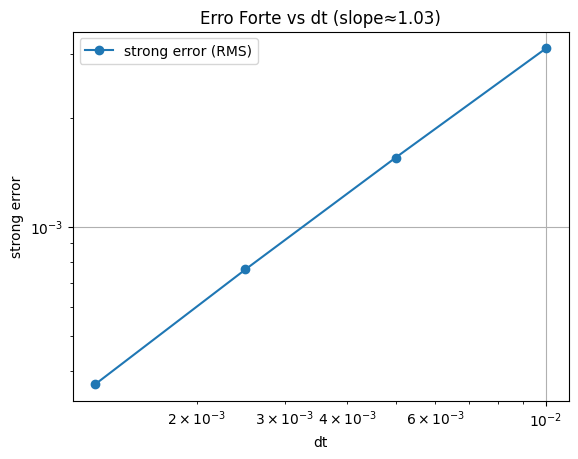

In [30]:
dts_arr = np.array(list(results.keys()))
strongs = np.array([results[dt]['strong_err'] for dt in dts_arr])
plt.figure()
plt.loglog(dts_arr, strongs, 'o-', label='strong error (RMS)')
# fit slope (evitar log de zero)
slope = np.nan
if np.all(strongs > 0):
    slope = np.polyfit(np.log(dts_arr), np.log(strongs), 1)[0]
plt.title(f'Erro Forte vs dt (slope≈{slope:.2f})')
plt.xlabel('dt'); plt.ylabel('strong error'); plt.grid(True); plt.legend()
plt.show()

Gráfico $\log-\log$: Média & Variância do Erro Fraco $\times$ $dt$:

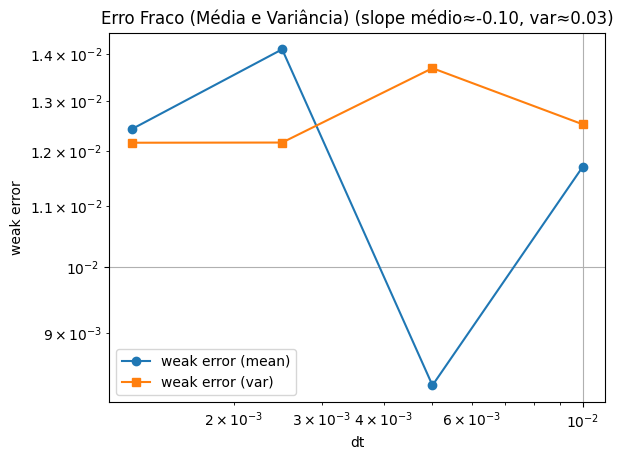

In [32]:
weak_mean = np.array([results[dt]['weak_err_mean'] for dt in dts_arr])
weak_var = np.array([results[dt]['weak_err_var'] for dt in dts_arr])
plt.figure()
plt.loglog(dts_arr, weak_mean, 'o-', label='weak error (mean)')
plt.loglog(dts_arr, weak_var, 's-', label='weak error (var)')
slope_mean = np.nan; slope_var = np.nan
if np.all(weak_mean > 0):
    slope_mean = np.polyfit(np.log(dts_arr), np.log(weak_mean), 1)[0]
if np.all(weak_var > 0):
    slope_var = np.polyfit(np.log(dts_arr), np.log(weak_var), 1)[0]
plt.title(f'Erro Fraco (Média e Variância) (slope médio≈{slope_mean:.2f}, var≈{slope_var:.2f})')
plt.xlabel('dt'); plt.ylabel('weak error'); plt.grid(True); plt.legend()
plt.show()

Histograma Empírico x Gaussiana Teórica (para o menor $dt$):

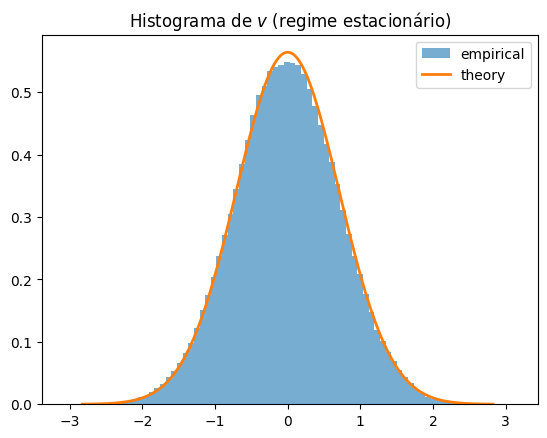

In [29]:
dt0 = dts_arr[-1]
v_sample = results[dt0]['v_samples']  # shape (M, N)
last_idx = int(0.5 * v_sample.shape[1])
samples = v_sample[:, last_idx:].ravel()
plt.figure()
plt.hist(samples, bins=80, density=True, alpha=0.6, label='empirical')
xs = np.linspace(-4*np.sqrt(sigma**2/(2*gamma*m)), 4*np.sqrt(sigma**2/(2*gamma*m)), 200)
plt.plot(xs, stats.norm.pdf(xs, 0, np.sqrt(sigma**2/(2*gamma*m))), label='theory', lw=2)
plt.title('Histograma de $v$ (regime estacionário)')
plt.legend()
plt.show()

Painel 2×2: trajetória, histograma, autocorrelação e erro forte

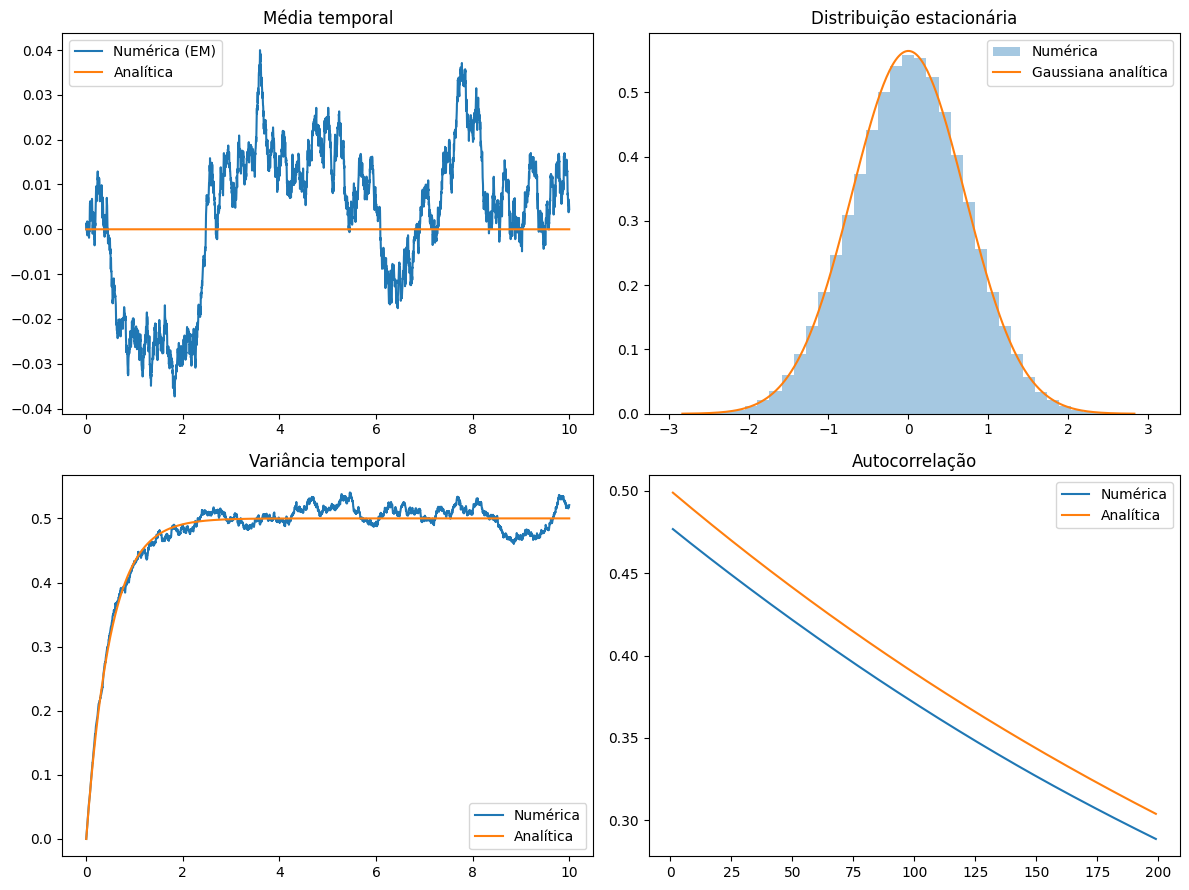

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

dt_show = list(results.keys())[2]   # ou escolha outro
res = results[dt_show]

t = res["t"]
mean_c = res["mean_c"]
var_c = res["var_c"]
v_all = res["v_samples"]

# Distribuição analítica estacionária
mu0 = 0.0
sigma_stat = np.sqrt((sigma**2)/(2*gamma*m))

# Autocorrelação teórica
lags = np.arange(1, 200)
Cv_th_plot = Cv_theo(lags * dt_show)

fig, axs = plt.subplots(2, 2, figsize=(12, 9))

# 1 — Trajetória média
axs[0,0].plot(t, mean_c, label="Numérica (EM)")
axs[0,0].plot(t, v_mean_theo(0, t), label="Analítica")
axs[0,0].set_title("Média temporal")
axs[0,0].legend()

# 2 — Histograma estacionário
samples = v_all[:, int(0.5*len(t)) : ].ravel()
axs[0,1].hist(samples, bins=40, density=True, alpha=0.4, label="Numérica")
xs = np.linspace(-4*sigma_stat, 4*sigma_stat, 300)
axs[0,1].plot(xs, 1/(sigma_stat*np.sqrt(2*np.pi))*np.exp(-(xs-mu0)**2/(2*sigma_stat**2)), 
              label="Gaussiana analítica")
axs[0,1].set_title("Distribuição estacionária")
axs[0,1].legend()

# 3 — Variância
axs[1,0].plot(t, var_c, label="Numérica")
axs[1,0].plot(t, v_var_theo(t), label="Analítica")
axs[1,0].set_title("Variância temporal")
axs[1,0].legend()

# 4 — Autocorrelação
# Empírica
maxlag = min(200, v_all.shape[1]-1)
emp_ac = []
for lag in range(1, maxlag):
    emp_ac.append((v_all[:, :-lag] * v_all[:, lag:]).mean())
emp_ac = np.array(emp_ac)

axs[1,1].plot(lags[:len(emp_ac)], emp_ac, label="Numérica")
axs[1,1].plot(lags, Cv_th_plot, label="Analítica")
axs[1,1].set_title("Autocorrelação")
axs[1,1].legend()

plt.tight_layout()
plt.show()

Curvas empilhadas de várias trajetórias (analítica × numérica)

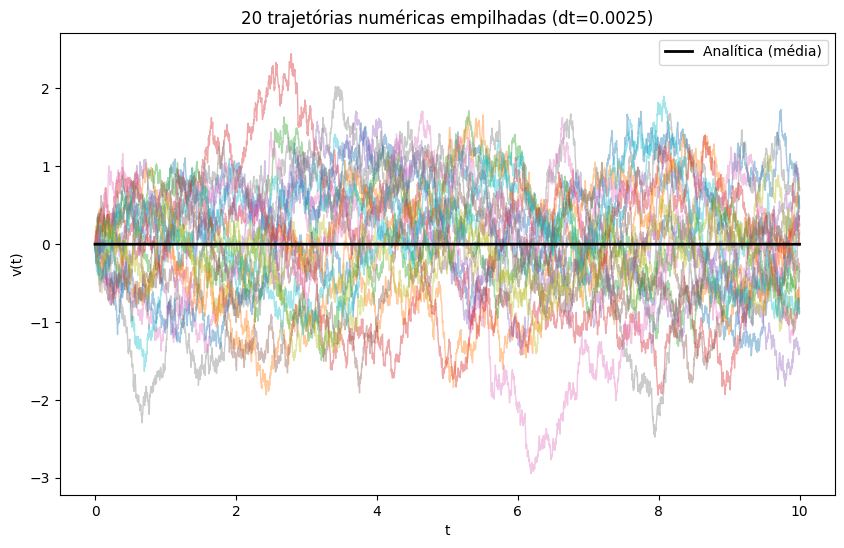

In [22]:
plt.figure(figsize=(10,6))

# Trajetórias
num_traj = 20
for i in range(num_traj):
    plt.plot(t, v_all[i], alpha=0.4, lw=1)

# Trajetória analítica média para comparação
plt.plot(t, v_mean_theo(0, t), color="black", lw=2, label="Analítica (média)")

plt.title(f"{num_traj} trajetórias numéricas empilhadas (dt={dt_show})")
plt.xlabel("t")
plt.ylabel("v(t)")
plt.legend()
plt.show()

Heatmap do ensemble completo

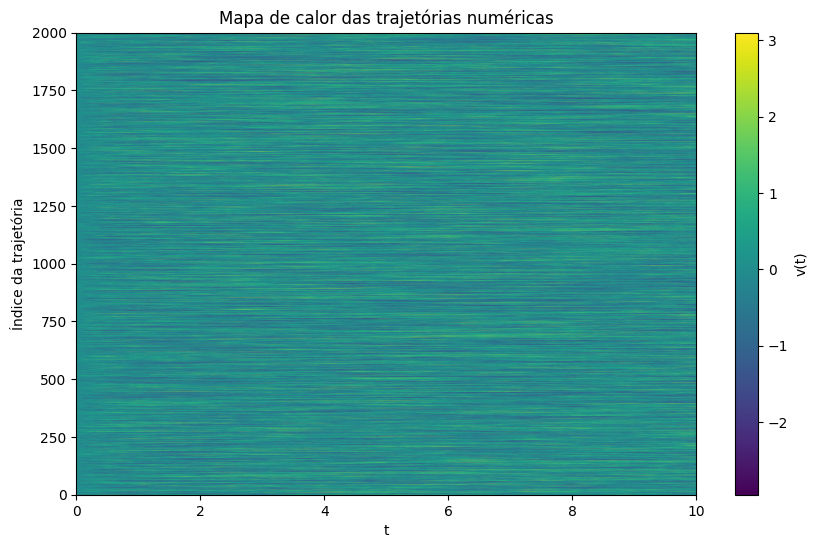

In [23]:
plt.figure(figsize=(10,6))
plt.imshow(v_all, aspect='auto', cmap="viridis",
           extent=[t[0], t[-1], 0, v_all.shape[0]])
plt.colorbar(label="v(t)")
plt.title("Mapa de calor das trajetórias numéricas")
plt.xlabel("t")
plt.ylabel("Índice da trajetória")
plt.show()

Gráfico lado a lado: trajetória analítica × numérica com faixa de erro

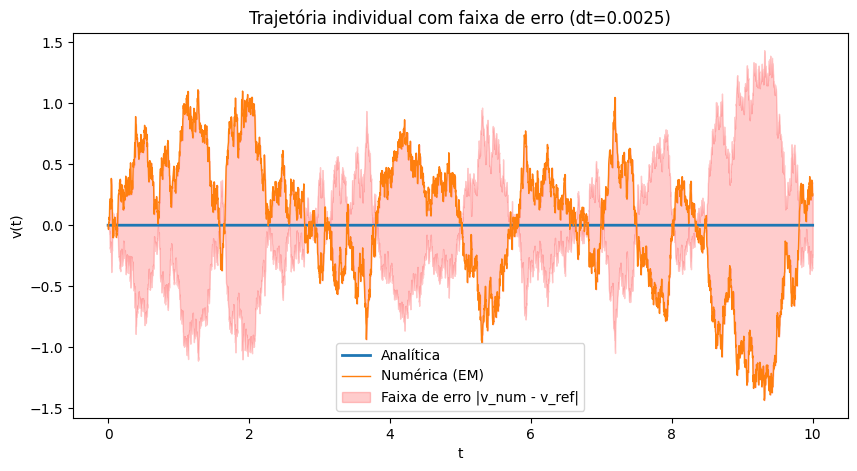

In [24]:
num_path = 0  # escolha uma trajetória
v_num = v_all[num_path]
v_ref = v_mean_theo(0, t)  # média analítica (pode trocar por solução analítica exata)

plt.figure(figsize=(10,5))
plt.plot(t, v_ref, label="Analítica", lw=2)
plt.plot(t, v_num, label="Numérica (EM)", lw=1)

err = np.abs(v_ref - v_num)
plt.fill_between(t, v_ref - err, v_ref + err, color="red", alpha=0.2,
                 label="Faixa de erro |v_num - v_ref|")

plt.title(f"Trajetória individual com faixa de erro (dt={dt_show})")
plt.xlabel("t")
plt.ylabel("v(t)")
plt.legend()
plt.show()

Comparação de distribuições via KDE 2D

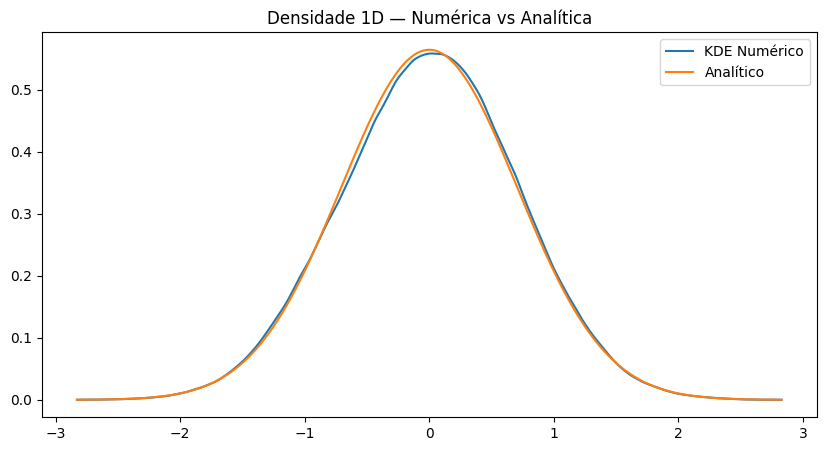

In [25]:
samples = v_all[:, int(len(t)*0.5) : ].ravel()

plt.figure(figsize=(10,5))
density = gaussian_kde(samples)
xs = np.linspace(-4*sigma_stat, 4*sigma_stat, 500)
plt.plot(xs, density(xs), label="KDE Numérico")
plt.plot(xs, 1/(sigma_stat*np.sqrt(2*np.pi))*np.exp(-(xs-mu0)**2/(2*sigma_stat**2)),
         label="Analítico")
plt.title("Densidade 1D — Numérica vs Analítica")
plt.legend()
plt.show()

Curva log–log: erro forte vs passo (ordem de convergência)

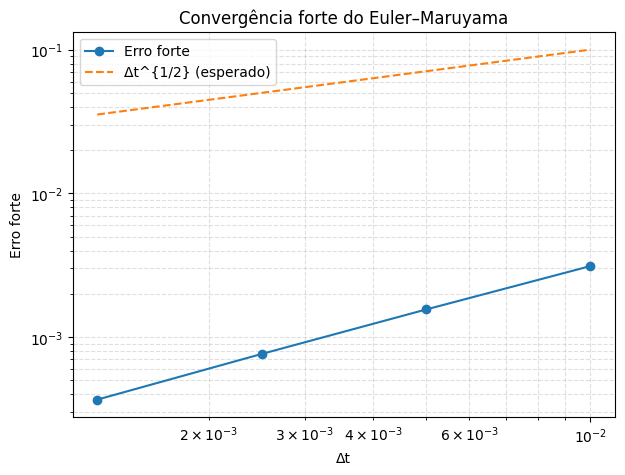

In [26]:
dts_arr = np.array(sorted(results.keys()))
strong_arr = np.array([results[dt]["strong_err"] for dt in dts_arr])

plt.figure(figsize=(7,5))
plt.loglog(dts_arr, strong_arr, 'o-', label="Erro forte")
plt.loglog(dts_arr, dts_arr**0.5, '--', label="Δt^{1/2} (esperado)")
plt.xlabel("Δt")
plt.ylabel("Erro forte")
plt.title("Convergência forte do Euler–Maruyama")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

Área acumulada do erro (AUC do erro temporal)

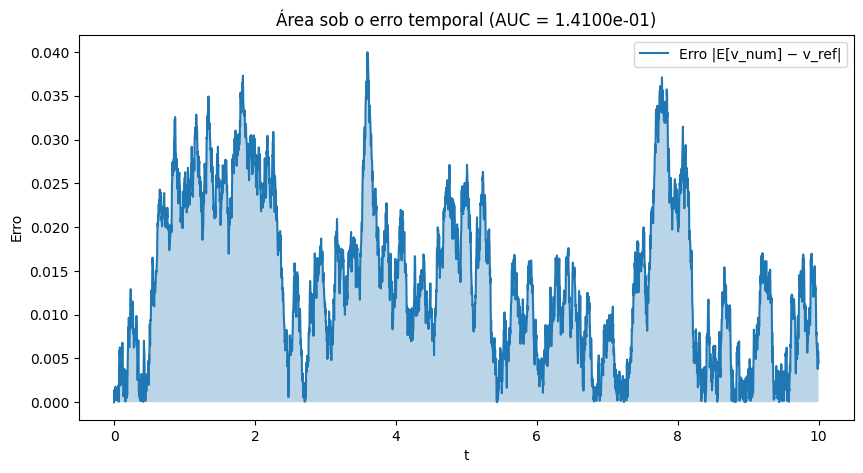

In [33]:
v_ref_sub = v_mean_theo(0, t)
err_time = np.abs(v_all.mean(axis=0) - v_ref_sub)
auc = np.trapezoid(err_time, t)

plt.figure(figsize=(10,5))
plt.plot(t, err_time, label="Erro |E[v_num] − v_ref|")
plt.fill_between(t, 0, err_time, alpha=0.3)
plt.title(f"Área sob o erro temporal (AUC = {auc:.4e})")
plt.xlabel("t")
plt.ylabel("Erro")
plt.legend()
plt.show()

Plot de fase (x vs v)

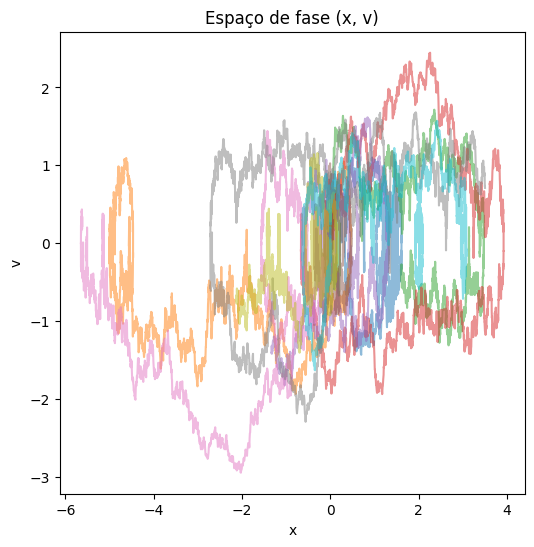

In [28]:
x_all = res["v_samples"].cumsum(axis=1) * dt_show

plt.figure(figsize=(6,6))
for i in range(10):
    plt.plot(x_all[i], v_all[i], alpha=0.5)

plt.title("Espaço de fase (x, v)")
plt.xlabel("x")
plt.ylabel("v")
plt.show()

# Referências

COFFEY, W.; KALMYKOV, Y. P.; WALDRON, J. T. The Langevin Equation. World Scientific, 2004.

GRØNBECH-JENSEN, N.; FARAGO, O. A simple and effective Verlet-type algorithm for Langevin dynamics. Molecular Physics, 2013.

HIGHAM, D. J. An algorithmic introduction to numerical simulation of stochastic differential equations. SIAM Review, 2001.

KLOEDEN, P. E.; PLATEN, E. Numerical Solution of Stochastic Differential Equations. Springer, 1992.

MEDIUM. Simulating Brownian Motion and Stock Prices using Python. Disponível em: https://medium.com/@mlblogging.k/simulating-brownian-motion-and-stock-prices-using-python-17b6b4bd2a1. Acesso em: 23 nov. 2025.

NUMPY. NumPy Documentation. Disponível em: https://numpy.org/. Acesso em: 24 nov. 2025.

ØKSENDAL, B. Stochastic Differential Equations: An Introduction with Applications. Springer, 2003.

ORNSTEIN–UHLENBECK PROCESS. Wikipedia. Disponível em: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process. Acesso em: 24 nov. 2025.

QUANTSTART. Brownian motion simulation with Python. Disponível em: https://www.quantstart.com/articles/brownian-motion-simulation-with-python/. Acesso em: 24 nov. 2025.

QUANTSTART. Ornstein–Uhlenbeck simulation with Python. Disponível em: https://www.quantstart.com/articles/ornstein-uhlenbeck-simulation-with-python/. Acesso em: 24 nov. 2025.

SÄRKKÄ, S.; SOLIN, A. Applied Stochastic Differential Equations. Cambridge University Press, 2019.

SCIPY. SciPy Documentation. Disponível em: https://scipy.org/. Acesso em: 24 nov. 2025.

UHLENBECK, G. E.; ORNSTEIN, L. S. On the theory of the Brownian motion. Physical Review, 1930.